# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



Instructions for updating:
non-resource variables are not supported in the long term


# 1) Load Data

In [2]:
train_dataset_path = 'data/train/'
validation_dataset_path = 'data/test/'

# 2) Augment the Images

In [3]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

### (i) Load the training data and augment

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='sparse',
                                                   shuffle=True)

Found 1050 images belonging to 5 classes.


### (ii) Load the validation data and augment

In [5]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='sparse',
                                                             shuffle=True)

Found 118 images belonging to 5 classes.


### (iii) Get the label mapping

In [6]:
# Each number from 0-134 should match to a class of images (See csv file).
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : 18
1 : 20
2 : 25
3 : 26
4 : 39


# 3) Plotting sample training images

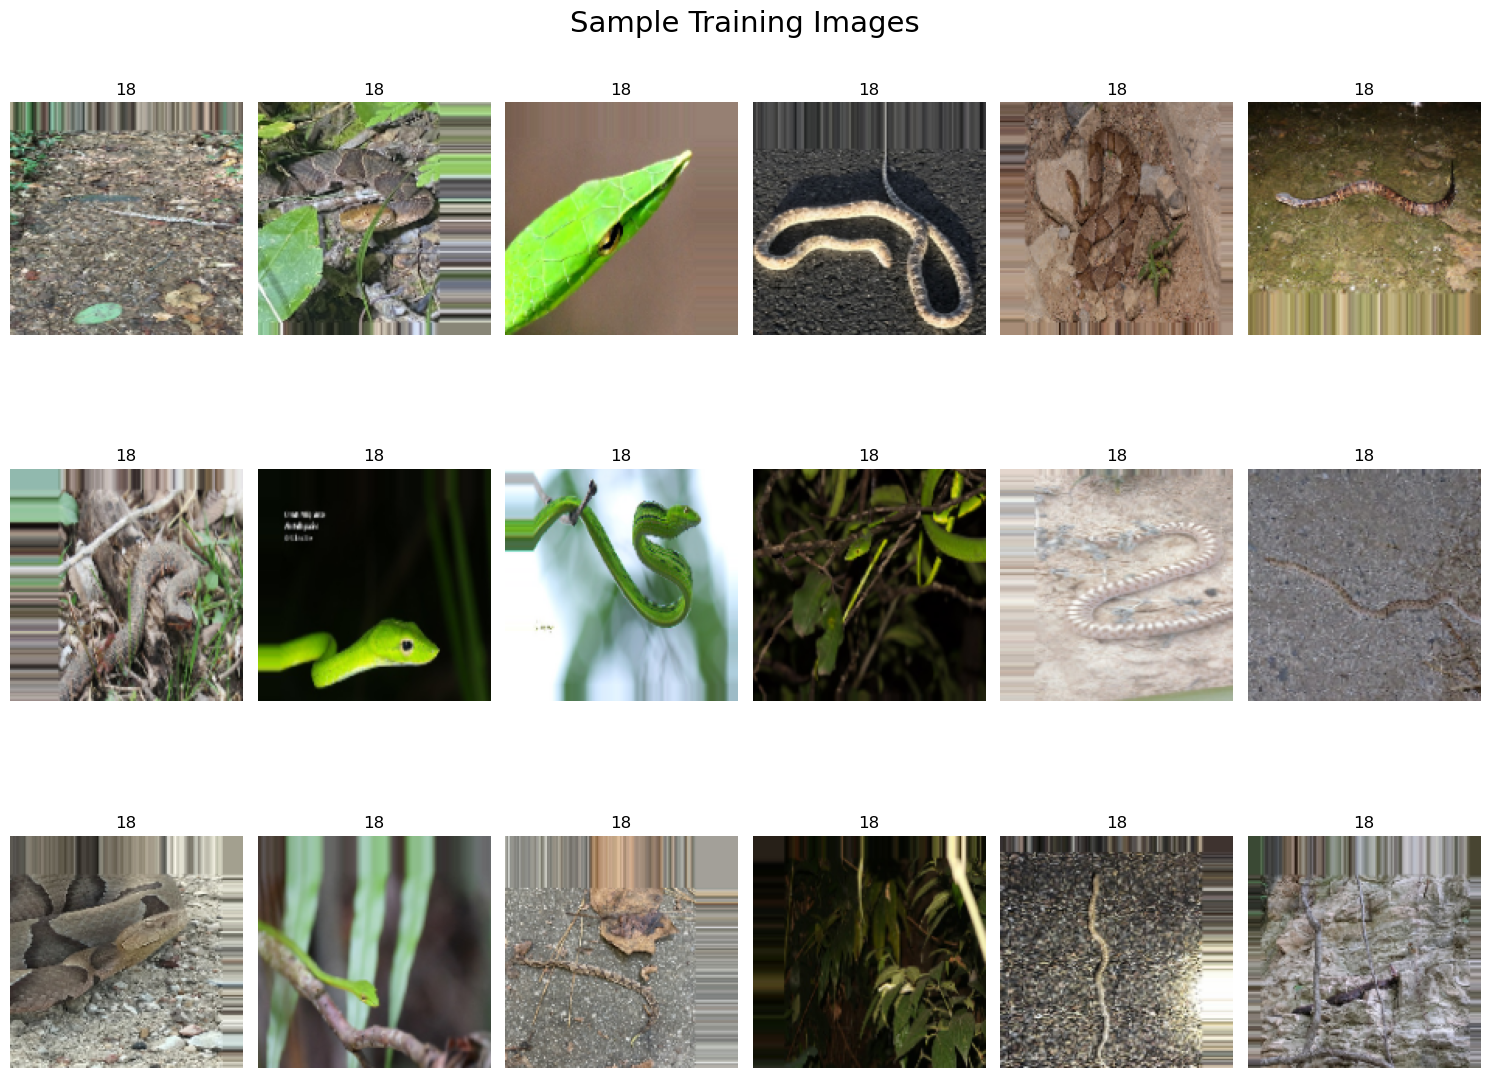

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(15, 12))
idx = 0

for i in range(3):
    for j in range(6):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# 4) Training the CNN model

### (i) Create the CNN model

In [8]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=135, activation='softmax')
    ])
    
    return model


In [9]:
cnn_model = create_model()



Instructions for updating:
Colocations handled automatically by placer.


In [10]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 activation (Activation)     (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0

### (ii) Defining callbacks

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [12]:
optimizer = Adam(learning_rate=0.001)

In [13]:
cnn_model.compile(optimizer='adam', 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])

In [14]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])


Epoch 1/50

33/33 - 38s - loss: 4.4711 - acc: 0.3019 - val_loss: 1.9845 - val_acc: 0.1695 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 2/50
33/33 - 38s - loss: 3.7507 - acc: 0.3248 - val_loss: 2.2149 - val_acc: 0.1695 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 3/50
33/33 - 37s - loss: 3.3005 - acc: 0.3562 - val_loss: 2.4763 - val_acc: 0.1780 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 4/50
33/33 - 33s - loss: 2.9803 - acc: 0.3876 - val_loss: 2.0863 - val_acc: 0.2119 - lr: 0.0010 - 33s/epoch - 995ms/step
Epoch 5/50
33/33 - 33s - loss: 2.5852 - acc: 0.4010 - val_loss: 2.4088 - val_acc: 0.3305 - lr: 0.0010 - 33s/epoch - 998ms/step
Epoch 6/50
33/33 - 32s - loss: 2.3789 - acc: 0.4000 - val_loss: 2.4203 - val_acc: 0.3390 - lr: 0.0010 - 32s/epoch - 982ms/step
Epoch 7/50
33/33 - 33s - loss: 1.8555 - acc: 0.4276 - val_loss: 1.6130 - val_acc: 0.3136 - lr: 3.1623e-04 - 33s/epoch - 985ms/step
Epoch 8/50
33/33 - 33s - loss: 1.6002 - acc: 0.4581 - val_loss: 1.5844 - val_acc: 0.3644 - lr: 3.1623e-04 - 33s/ep

In [15]:
print("DONE")

DONE


# Plotting the Metrics

### Plotting training and validation accuracy, loss, and learning rate

In [16]:
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

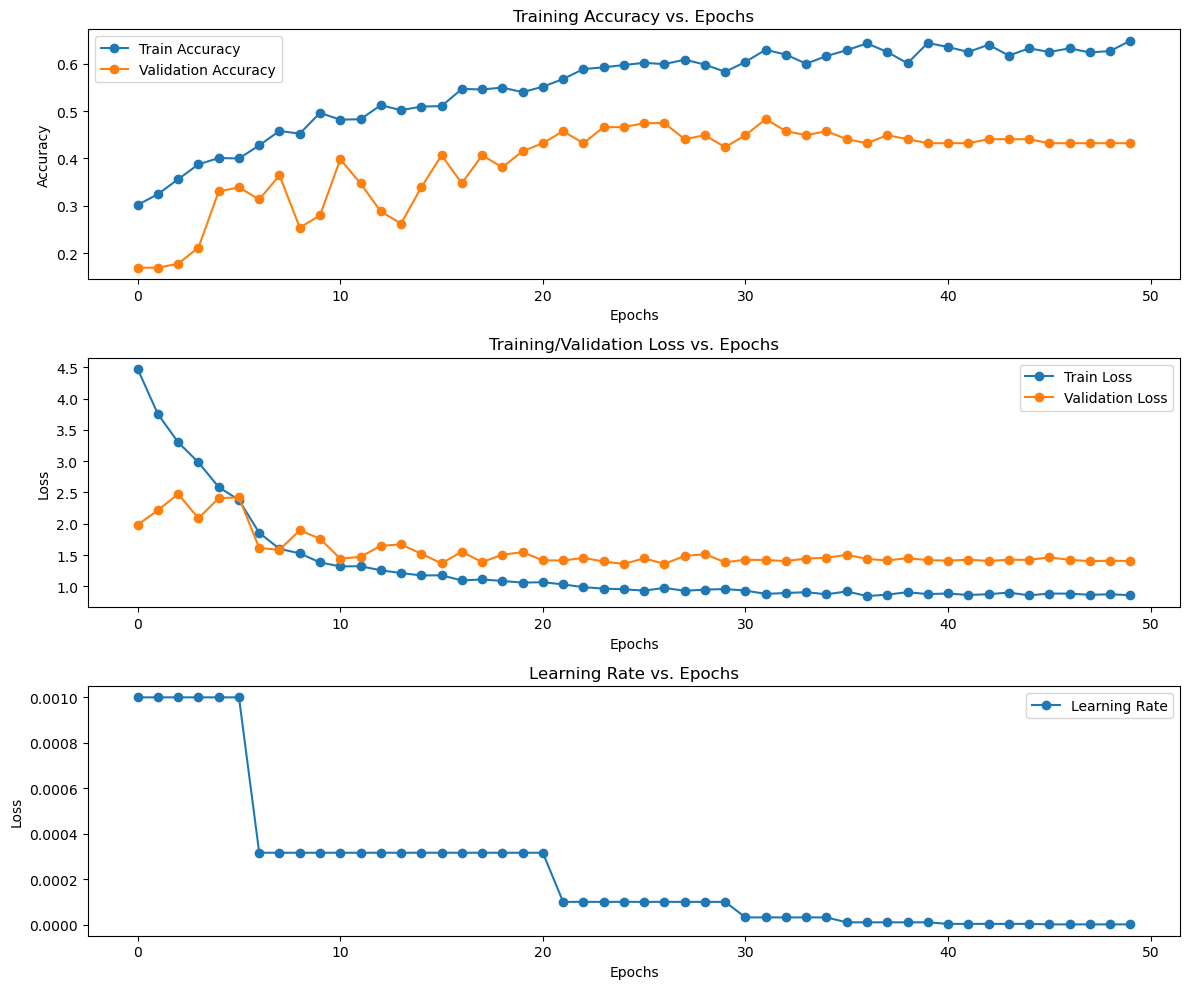

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

# Testing the model

In [18]:
test_dataset = 'data/test/'

In [19]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='sparse')

Found 118 images belonging to 5 classes.


# Model Prediction on Test Dataset

In [20]:
predictions = cnn_model.predict(test_generator)

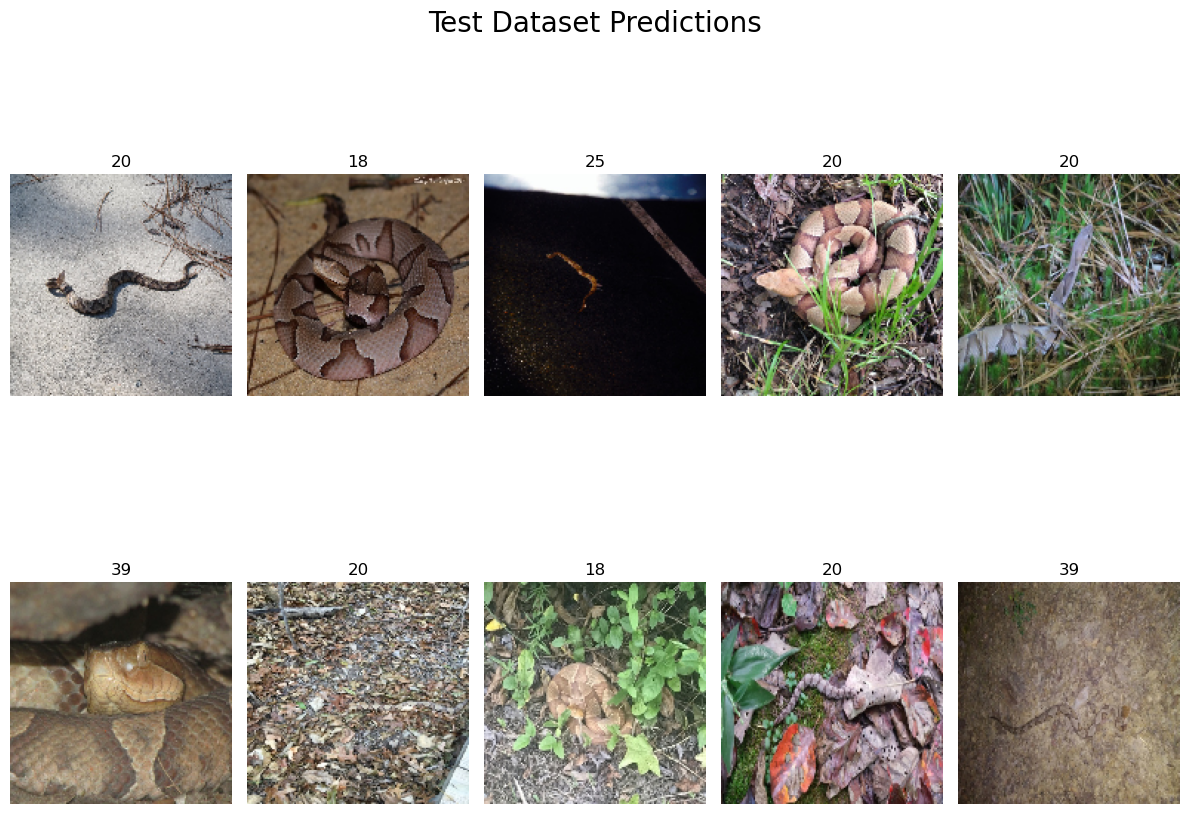

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [22]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=None)

In [23]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     1.4099222421646118
Test Accuracy: 0.43220338225364685


# Plotting the Classification Metrics

In [24]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

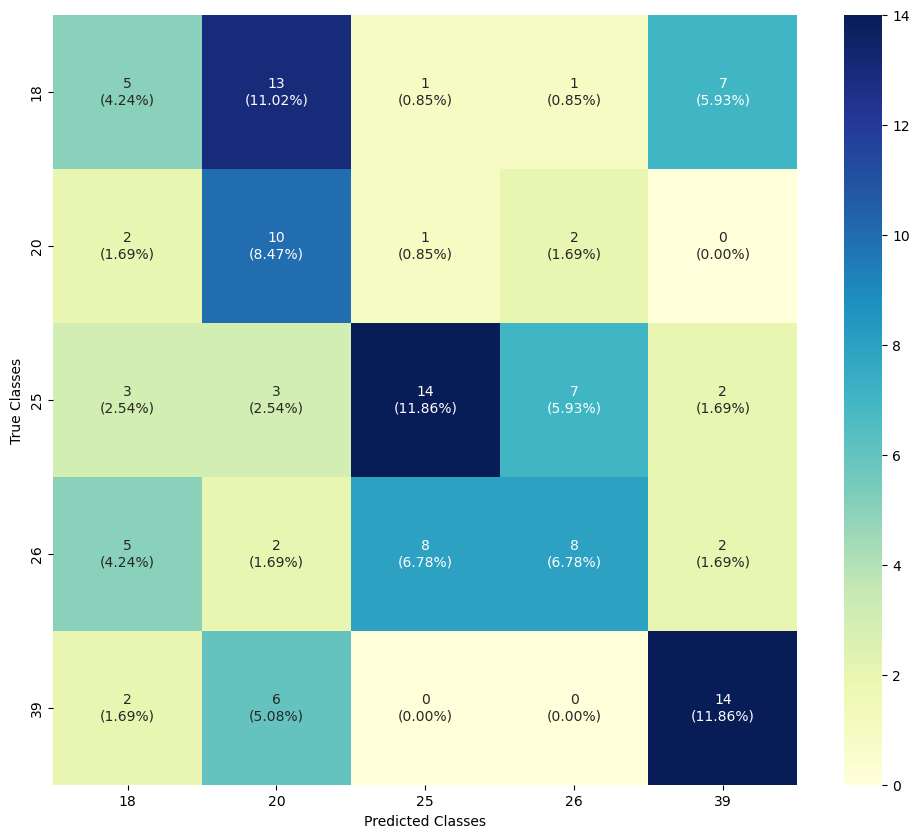

In [25]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(5, 5)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [26]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

          18       0.29      0.19      0.23        27
          20       0.29      0.67      0.41        15
          25       0.58      0.48      0.53        29
          26       0.44      0.32      0.37        25
          39       0.56      0.64      0.60        22

    accuracy                           0.43       118
   macro avg       0.44      0.46      0.43       118
weighted avg       0.45      0.43      0.42       118



# Wrong Predictions

In [27]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [28]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

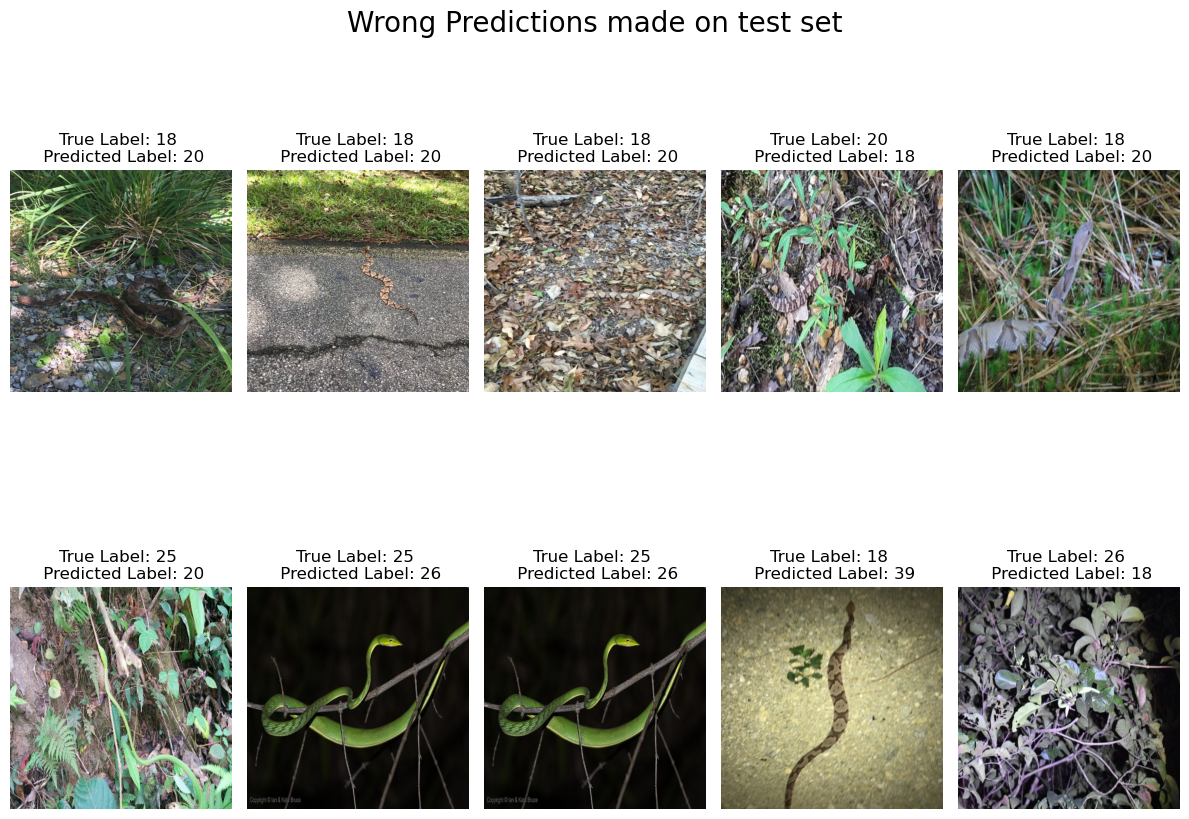

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

# Save CNN to TFLITE File

In [54]:
#import all the requirements 
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [57]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpyhbk4y_2\assets


INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpyhbk4y_2\assets


In [58]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)